# Data Science for Business

## Spring 2020, module 4 @ HSE

---

## Home assignment 5


Author: **Miron Rogovets**

---

You goal for this task is two fold:

1. Cluster all the products into distinct groups (clusters)
2. Build a recommender system for customers, but instead of products we will recommend categories.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm 

from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

In [2]:
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
sns.set_style('darkgrid')

In [3]:
df = pd.read_csv('data/sample_transations.csv', index_col=0)
df.head(3)

,dd_card_number,store_number,dd_transaction_number,sku,quantity,post_discount_price,date,hour,dbi_item_catgry,dbi_item_sub_catgry,dbi_item_famly_name,dbi_item_size
0,0,775,7969,74,1,2.29,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Large
1,0,775,7969,73,1,0.00,9/2/2015,Lunch,Beverages,Hot Coffee,Hot Coffee,Medium
2,0,761,16021,75,1,2.49,9/4/2015,Morning,Beverages,Hot Coffee,Hot Coffee,X-Large


In [4]:
df.shape

(51939, 12)

In [5]:
df.dtypes

dd_card_number             int64
store_number               int64
dd_transaction_number      int64
sku                        int64
quantity                   int64
post_discount_price      float64
date                      object
hour                      object
dbi_item_catgry           object
dbi_item_sub_catgry       object
dbi_item_famly_name       object
dbi_item_size             object
dtype: object

In [6]:
df.isna().sum()

dd_card_number           0
store_number             0
dd_transaction_number    0
sku                      0
quantity                 0
post_discount_price      0
date                     0
hour                     0
dbi_item_catgry          0
dbi_item_sub_catgry      0
dbi_item_famly_name      0
dbi_item_size            0
dtype: int64

- `dd_card_number` - customer identifier (categorical)
- `store_number` - store identifier (categorical)
- `dd_transaction_number` - transaction identifier (categorical)
- `sku` - product identifier, may vary across different stores (categorical)
- `quantity` - quantity (numerical)
- `post_discount_price` - transaction price (numerical)
- `date` - transaction date 
- `hour` (categorical)
- `dbi_item_catgry` (categorical)
- `dbi_item_sub_catgry` (categorical)
- `dbi_item_famly_name` (categorical)
- `dbi_item_size` (categorical)


### Data Exploration

In [7]:
df.duplicated().sum()

1273

In [8]:
#data = df.drop_duplicates().copy()
df.drop_duplicates(inplace=True)
df['weekday'] = pd.to_datetime(df['date']).dt.dayofweek
df.shape

(50666, 13)

In [9]:
df.nunique()

dd_card_number             100
store_number              1501
dd_transaction_number    24348
sku                        620
quantity                    11
post_discount_price        556
date                       365
hour                         4
dbi_item_catgry              5
dbi_item_sub_catgry         55
dbi_item_famly_name        120
dbi_item_size              103
weekday                      7
dtype: int64

In [10]:
original_features = df.columns
original_features

Index(['dd_card_number', 'store_number', 'dd_transaction_number', 'sku',
       'quantity', 'post_discount_price', 'date', 'hour', 'dbi_item_catgry',
       'dbi_item_sub_catgry', 'dbi_item_famly_name', 'dbi_item_size',
       'weekday'],
      dtype='object')

In [11]:
df['dbi_item_catgry'].value_counts()

Beverages        30004
Food - Bakery    13786
Food AM           6181
Food PM            427
Other              268
Name: dbi_item_catgry, dtype: int64

In [12]:
df['hour'].value_counts()

Morning      29029
Lunch        14294
Afternoon     5467
Night         1876
Name: hour, dtype: int64

In [13]:
df['dbi_item_sub_catgry'].value_counts()

Hot Coffee                                 15648
Iced Coffee                                 8882
Donut Varieties                             6254
Bagels                                      3880
Muffin                                      3117
Wake Up Wraps                               2226
Hash Brown                                  1139
Iced Espresso                               1121
Iced Tea                                    1036
Frozen Beverages                             805
Hot Espresso                                 744
Cooler Beverages                             683
Bacon, Egg & Cheese                          658
Hot Tea                                      625
Egg & Cheese                                 596
Sausage, Egg & Cheese                        532
Other Hot Beverages                          451
Other Food- Bakery                           413
Egg White Flatbreads                         335
Turkey Sausage Sandwich                      275
K-Cups              

In [14]:
(df['post_discount_price'] == 0.0).sum()

7305

In [15]:
skus = df.groupby('dbi_item_famly_name')[['sku', 'store_number', 'dbi_item_size']].nunique()
skus[skus.sku > 1]

,sku,store_number,dbi_item_size
dbi_item_famly_name,,,
1 Fried Egg,2,4,1
1 lb,3,15,1
2 Fried Eggs (Big n Toasted),3,19,1
Almond Milk,8,42,1
Apparel,2,2,1
...,...,...,...
"Yellow, Scrambled Egg (Ham, Egg & Cheese)",10,45,5
"Yellow, Scrambled Egg (Maple Sausage Breakfast Sandwich)",3,15,3
"Yellow, Scrambled Egg (Sausage, Egg & Cheese)",15,147,6


---

### I. Clustering (20)

1. Feature generation. Use examples from Seminar 6 Plan to generate features for products clustering. You may generate any number of features but you must generate at least 3 features which differ from those, proposed in the plan.

### Features from seminar:

In [17]:
# average item price
df['mean_price'] = df.groupby('sku')['post_discount_price'].transform('mean')

# median quantity in a single purchase
df['med_purchase_quantity'] = df.groupby(['dd_transaction_number', 'sku'])['quantity'].transform('median')

# How many different stores sell this item
# df['store_count'] = df.groupby('sku')['store_number'].transform('nunique')

# How many different customers buy this item
df['cust_count'] = df.groupby('sku')['dd_card_number'].transform('nunique')

# Number of purchases at different hour
df['hour_purchase_count'] = df.groupby(['sku', 'hour'])['dd_transaction_number'].transform('nunique')

# Ratio of purchases within a day for a store
df['store_daily_ratio'] = df.groupby(['sku', 'date', 'store_number']) \
['dd_transaction_number'].transform('nunique') / \
df.groupby(['sku', 'date'])['dd_transaction_number'].transform('nunique')

# Number of other items in the same category
# df['cat_size'] = df.groupby('dbi_item_catgry')['sku'].transform('nunique') - 1 

# Number of other items in the same subcategory
df['subcat_size'] = df.groupby('dbi_item_sub_catgry')['sku'].transform('nunique') - 1 

# Average price of items in the same category
# df['cat_price'] = df.groupby('dbi_item_catgry')['post_discount_price'].transform('mean')

# Average price of items in the same subcategory
df['subcat_price'] = df.groupby('dbi_item_sub_catgry')['post_discount_price'].transform('mean')

In [18]:
# Not used:
# - Ratio of purchases within a week for a customers (averaged over all customers)
# - Number of purchases at different week day
# - How many different stores sell this item
# - category price / size

---

### Custom features

In [19]:
# how often item is purchased (days with purchases / total days)
df['freq'] = df.groupby(['sku'])['date'].transform('nunique') / df.date.nunique()

# Number of other items within same product family
df['fam_size'] = df.groupby('dbi_item_famly_name')['sku'].transform('nunique') - 1

# average price of items within same product family
df['fam_price'] = df.groupby('dbi_item_famly_name')['post_discount_price'].transform('mean')

# mean number of transactions a day
# n_daily = df.groupby(['sku', 'weekday'])['dd_transaction_number'].size().groupby('sku').mean()
# df['daily_purchase'] = df.sku.apply(lambda x: n_daily[x])

# weekday with maximum purchases
idx = df.groupby(['sku', 'weekday'])['dd_transaction_number'].size().groupby('sku').idxmax()
wdays = df.groupby(['sku', 'weekday'])['dd_transaction_number'].size().loc[idx].reset_index().set_index('sku').weekday
df['max_weekday'] = df.sku.apply(lambda x: wdays[x])

# Daily Quantity ratio at different hour
df['daily_hour_purchase_ratio'] = df.groupby(['sku', 'date', 'hour']) \
['quantity'].transform('sum') / df.groupby(['sku', 'date'])['quantity'].transform('sum')

In [20]:
df.columns

Index(['dd_card_number', 'store_number', 'dd_transaction_number', 'sku',
       'quantity', 'post_discount_price', 'date', 'hour', 'dbi_item_catgry',
       'dbi_item_sub_catgry', 'dbi_item_famly_name', 'dbi_item_size',
       'weekday', 'mean_price', 'med_purchase_quantity', 'cust_count',
       'hour_purchase_count', 'store_daily_ratio', 'subcat_size',
       'subcat_price', 'freq', 'fam_size', 'fam_price', 'max_weekday',
       'daily_hour_purchase_ratio'],
      dtype='object')

2. Cluster all products into distinct groups (clusters). You may use any clustering algorithm you want. If you use distance-based clustering (e.g. k-means), do not forget to preprocess your features (normalization, z-scoring or standard scaling). Try a different number of groups (e.g. from 5 to 30)

In [21]:
data = df.drop(columns=original_features)

In [22]:
data.columns

Index(['mean_price', 'med_purchase_quantity', 'cust_count',
       'hour_purchase_count', 'store_daily_ratio', 'subcat_size',
       'subcat_price', 'freq', 'fam_size', 'fam_price', 'max_weekday',
       'daily_hour_purchase_ratio'],
      dtype='object')

In [23]:
data.dtypes

mean_price                   float64
med_purchase_quantity        float64
cust_count                     int64
hour_purchase_count            int64
store_daily_ratio            float64
subcat_size                    int64
subcat_price                 float64
freq                         float64
fam_size                       int64
fam_price                    float64
max_weekday                    int64
daily_hour_purchase_ratio    float64
dtype: object

In [24]:
data.isna().sum().sum()

0

In [25]:
data.shape

(50666, 12)

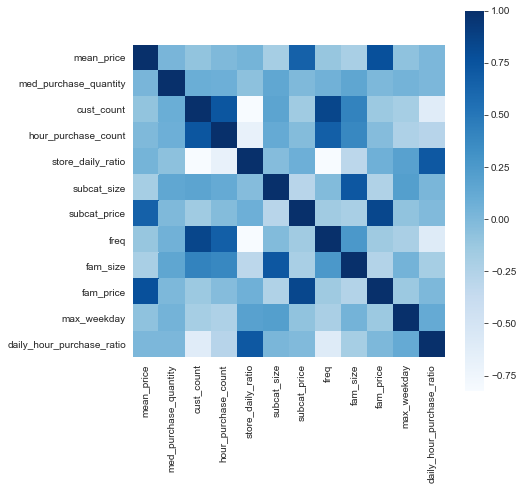

In [26]:
plt.figure(figsize=(7,7))
sns.heatmap(data.corr(), square = True, cmap='Blues')

In [27]:
(~data.corr()[abs(data.corr()) > 0.85].isna()).sum()

mean_price                   1
med_purchase_quantity        1
cust_count                   1
hour_purchase_count          1
store_daily_ratio            1
subcat_size                  1
subcat_price                 1
freq                         1
fam_size                     1
fam_price                    1
max_weekday                  1
daily_hour_purchase_ratio    1
dtype: int64

We do not have highly correlated variables, so we can proceed with clusterization

In [28]:
scaler = MinMaxScaler()
data[data.columns] = scaler.fit_transform(data[data.columns])
data.head()

,mean_price,med_purchase_quantity,cust_count,hour_purchase_count,store_daily_ratio,subcat_size,subcat_price,freq,fam_size,fam_price,max_weekday,daily_hour_purchase_ratio
0,0.06,0.00,0.86,0.44,0.07,0.35,0.11,1.00,0.54,0.05,0.17,0.28
1,0.05,0.00,0.94,0.45,0.15,0.35,0.11,1.00,0.54,0.05,0.17,0.31
2,0.06,0.00,0.44,0.64,0.11,0.35,0.11,1.00,0.54,0.05,0.33,1.00
3,0.05,0.00,0.09,0.02,1.00,0.35,0.11,0.32,0.54,0.05,0.67,1.00
4,0.05,0.00,0.09,0.02,1.00,0.35,0.11,0.32,0.54,0.05,0.67,1.00


In [29]:
# plt.figure(figsize=(25, 10))
# plt.title('Hierarchical Clustering Dendrogram')
# dendrogram = sch.dendrogram(sch.linkage(data, method='average'))
# plt.ylabel('distance')
# plt.show()

In [30]:
sums = []
K = range(1,80)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(data)
    sums.append(km.inertia_)

100%|██████████| 79/79 [09:33<00:00,  7.26s/it]


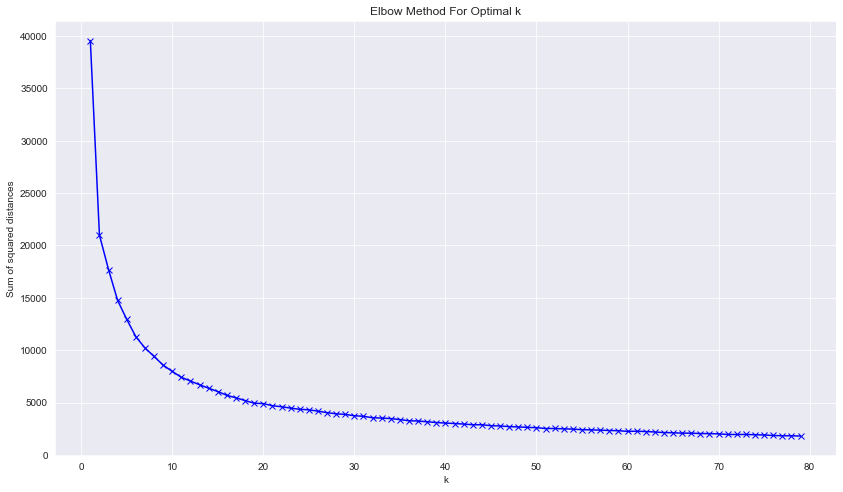

In [31]:
plt.figure(figsize=(14,8))
plt.plot(K, sums, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [40]:
for k in tqdm([15, 20, 25, 30]):
    kmeans = KMeans(n_clusters=k)
    predicted = kmeans.fit_predict(data)
    data[f'kmeans_{k}'] = predicted

100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


In [41]:
data.head(4)

,mean_price,med_purchase_quantity,cust_count,hour_purchase_count,store_daily_ratio,subcat_size,subcat_price,freq,fam_size,fam_price,max_weekday,daily_hour_purchase_ratio,kmeans_15,kmeans_20,kmeans_25,kmeans_30
0,0.06,0.00,0.86,0.44,0.07,0.35,0.11,1.00,0.54,0.05,0.17,0.28,9,2,4,9
1,0.05,0.00,0.94,0.45,0.15,0.35,0.11,1.00,0.54,0.05,0.17,0.31,9,2,4,9
2,0.06,0.00,0.44,0.64,0.11,0.35,0.11,1.00,0.54,0.05,0.33,1.00,3,11,17,20
3,0.05,0.00,0.09,0.02,1.00,0.35,0.11,0.32,0.54,0.05,0.67,1.00,1,8,24,17


3. Write a report. In your report you should present the following information:
   - Put an example screenshot of your features.
   - Explain (in a similar way I explain them in the plan) every single feature (you may skip features from the seminar plan) you use.
   - Cluster’s information: how many clusters do you have, how many objects are in these clusters.
   - Cluster’s interpretation. Try to provide an interpretation of every single cluster (or groups of clusters) you end up. For example: “Cluster 1 includes hot drinks and beverages often bought in a combination in the morning.”
   - You may include any visualization you find necessary, e.g.: colored PCA components, histogram or pie charts of cluster’s sizes, “elbows” used for selection number of clusters (if you have used it).


In [146]:
def describe_cluster(k, data, labels):
    print('======================================================================================================')
    print(f'Cluster number: {k}')
    cluster = data[labels == k]
    print(f'Cluster size: {cluster.shape[0]}\n')
    print(f"Mean price: {cluster['mean_price'].mean():.3f}")
    print(f"Mean customers count: {cluster['cust_count'].mean():.3f}")
    print(f"Mean freq: {cluster['freq'].mean():.3f}\n")
    
    f, ax = plt.subplots(3,2, figsize=(12, 12))
    sns.countplot(cluster['dbi_item_catgry'], ax=ax[0,0]).set_title('Categories')
    
    subcat = cluster['dbi_item_sub_catgry'].value_counts()[:6].index
    fam = cluster['dbi_item_famly_name'].value_counts()[:6].index
    sizes = cluster['dbi_item_size'].value_counts()[:6].index
    
    sns.countplot(
        cluster['dbi_item_sub_catgry'].where(
            cluster['dbi_item_sub_catgry'].isin(subcat), 'other'), 
        ax=ax[0, 1]).set_title('Top subategories')
    sns.countplot(
        cluster['dbi_item_famly_name'].where(
            cluster['dbi_item_famly_name'].isin(fam), 'other'), 
        ax=ax[1, 0]).set_title('Top family names')
    sns.countplot(
        cluster['dbi_item_size'].where(
            cluster['dbi_item_size'].isin(sizes), 'other'), 
        ax=ax[1,1]).set_title('Product sizes')
    
    sns.countplot(cluster['hour'], ax=ax[2,0]).set_title('Hour ratios')
    sns.countplot(cluster['quantity'], ax=ax[2,1]).set_title('Product quantity')
    
    for ax in f.axes[:-1]:
        if len(ax.xaxis.get_ticklabels()) > 4:
            plt.sca(ax)
            plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print('======================================================================================================')

Text(0.5, 1.0, 'Ckuster sizes')

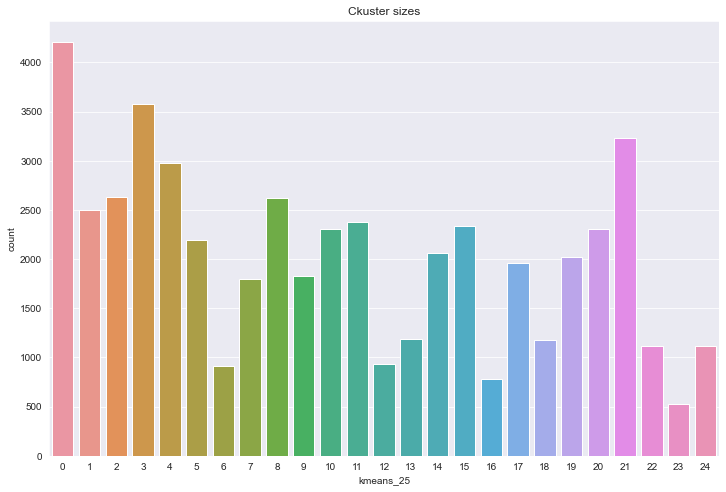

In [147]:
plt.figure(figsize=(12,8))
sns.countplot(data['kmeans_25']).set_title('Ckuster sizes')

Cluster number: 0
Cluster size: 4211

Mean price: 2.164
Mean customers count: 61.545
Mean freq: 0.706



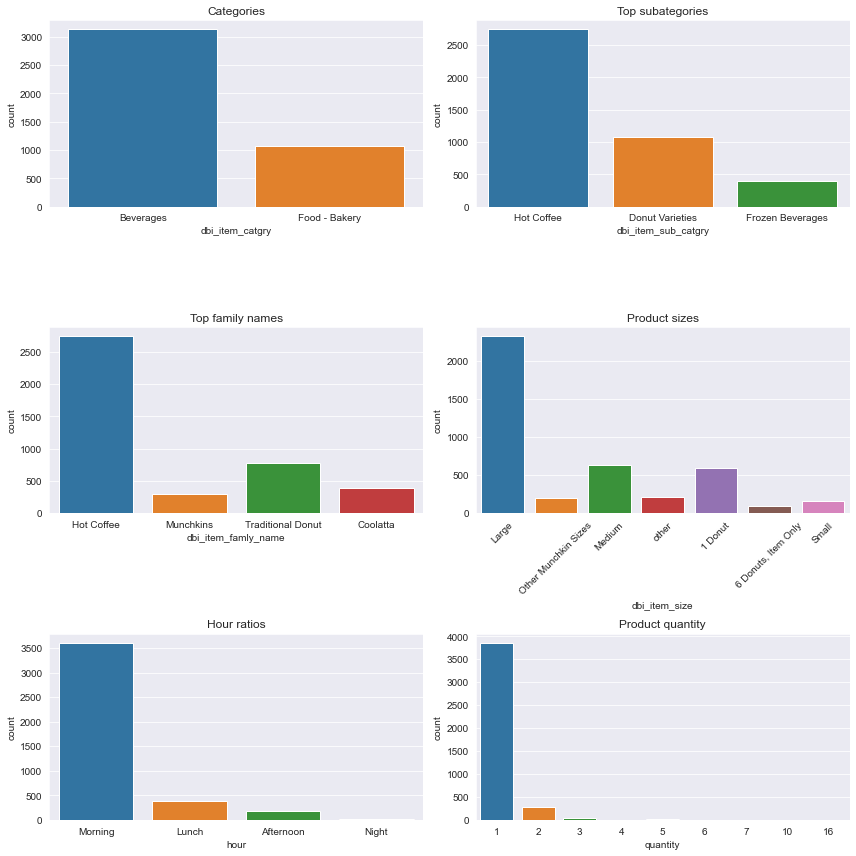

Cluster number: 1
Cluster size: 2499

Mean price: 1.999
Mean customers count: 90.977
Mean freq: 1.000



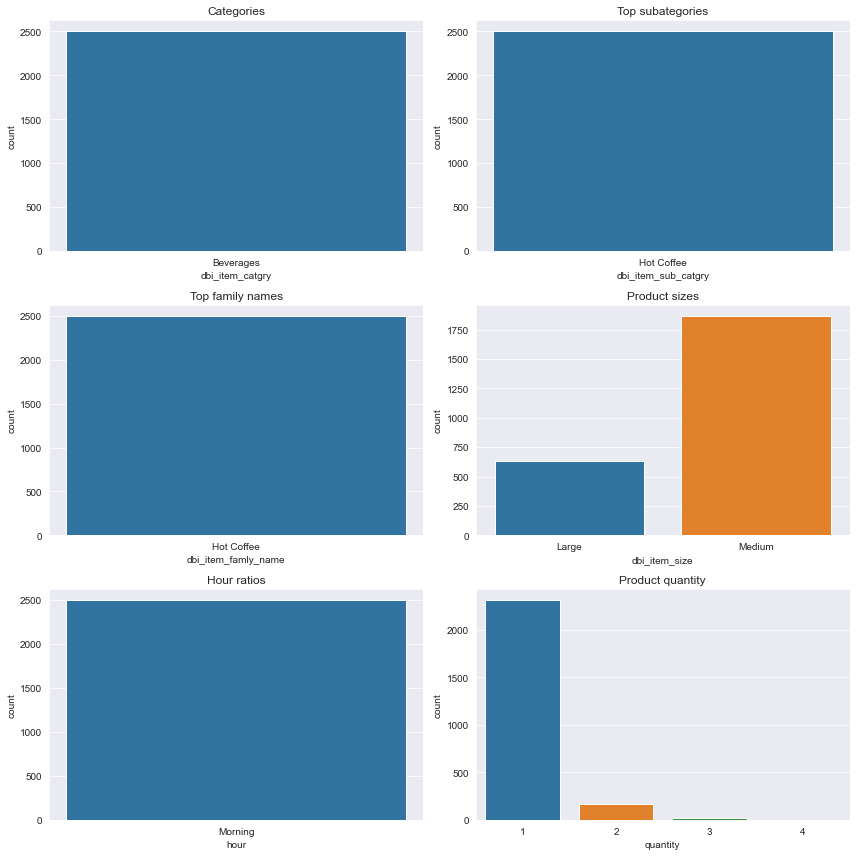

Cluster number: 2
Cluster size: 2627

Mean price: 1.600
Mean customers count: 31.750
Mean freq: 0.667



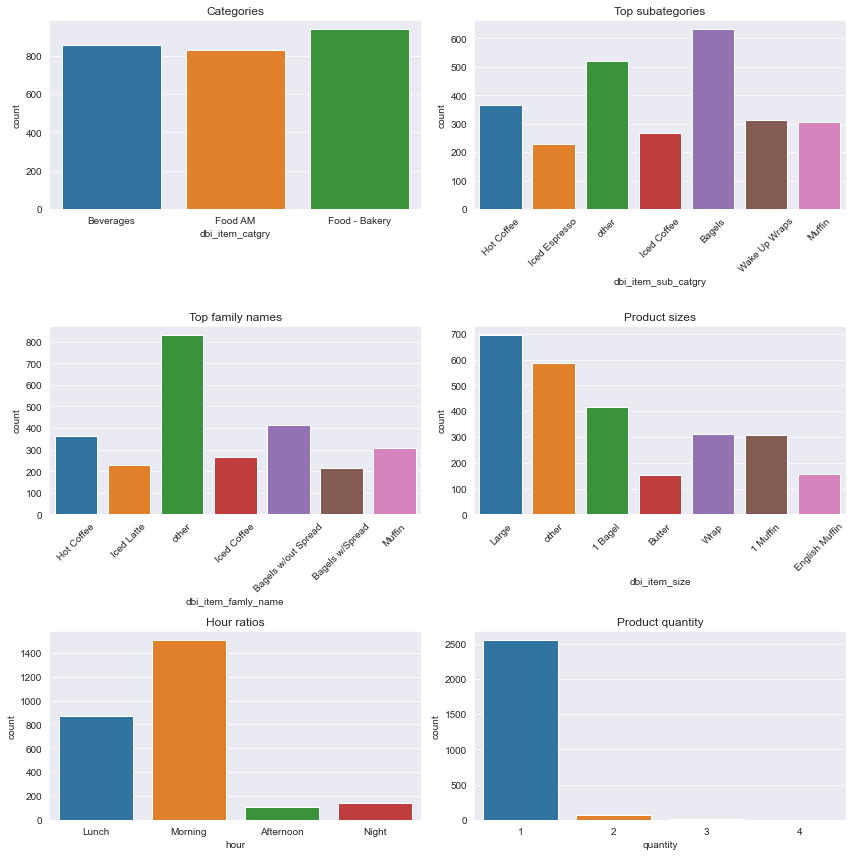

Cluster number: 3
Cluster size: 3577

Mean price: 2.113
Mean customers count: 36.015
Mean freq: 0.440



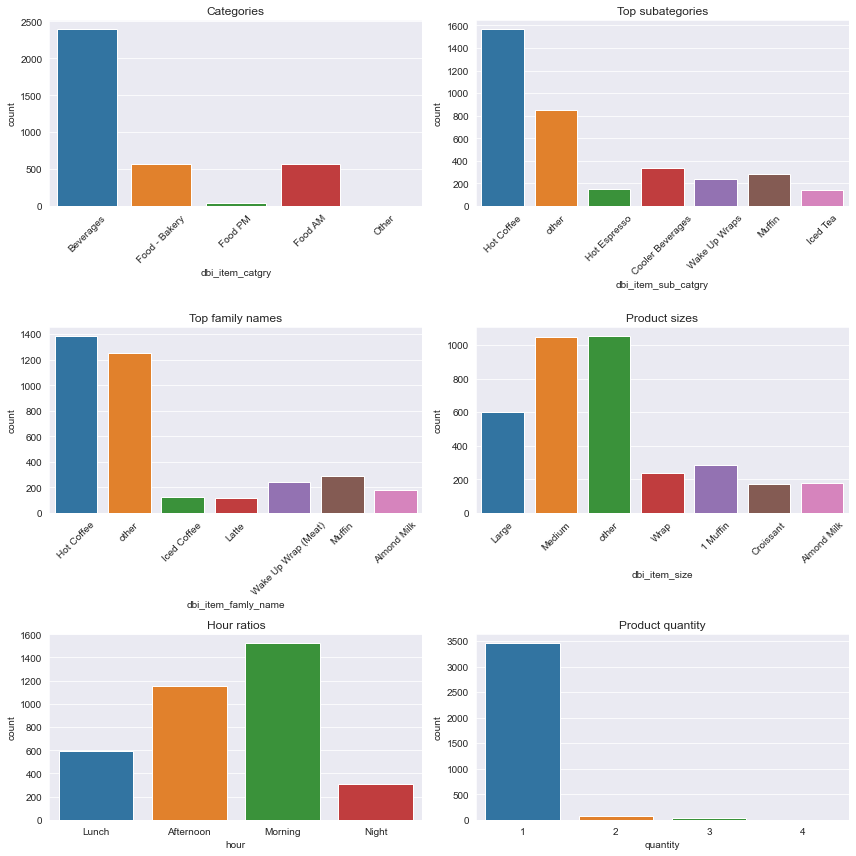

Cluster number: 4
Cluster size: 2980

Mean price: 2.049
Mean customers count: 89.471
Mean freq: 1.000



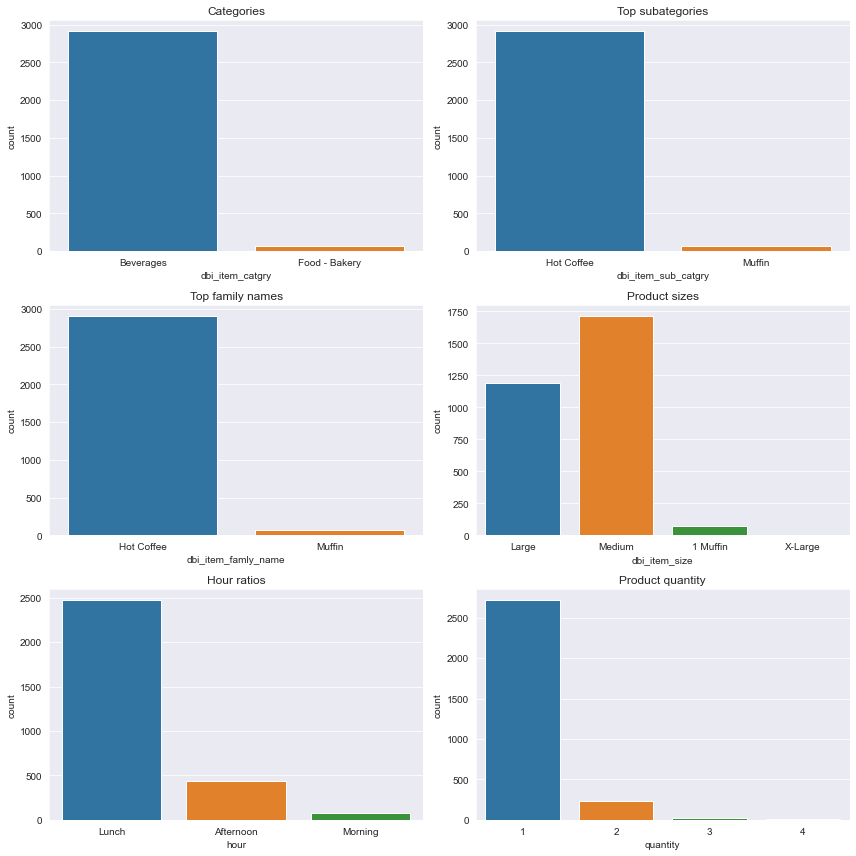

Cluster number: 5
Cluster size: 2194

Mean price: 2.123
Mean customers count: 70.209
Mean freq: 0.967



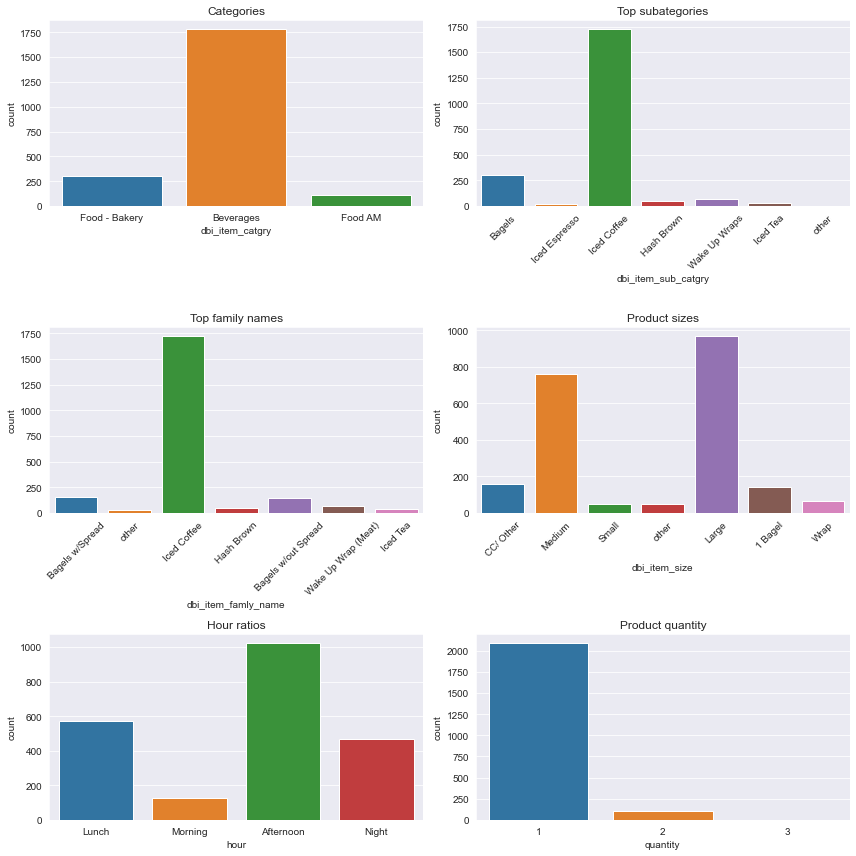

Cluster number: 6
Cluster size: 911

Mean price: 1.964
Mean customers count: 19.243
Mean freq: 0.356



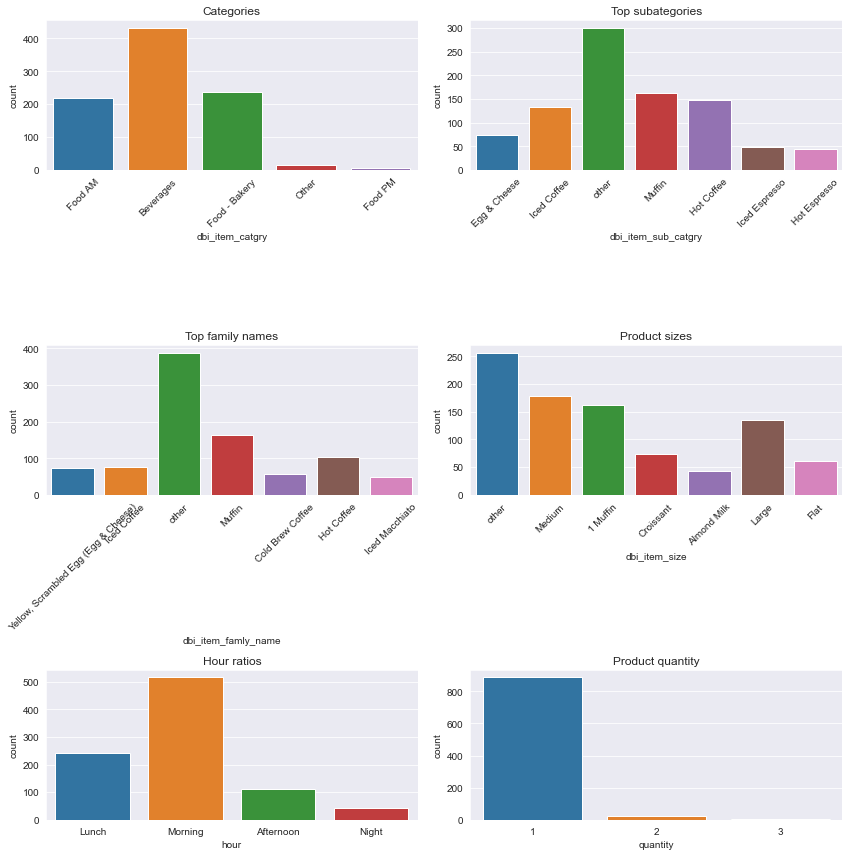

Cluster number: 7
Cluster size: 1799

Mean price: 1.176
Mean customers count: 42.951
Mean freq: 0.753



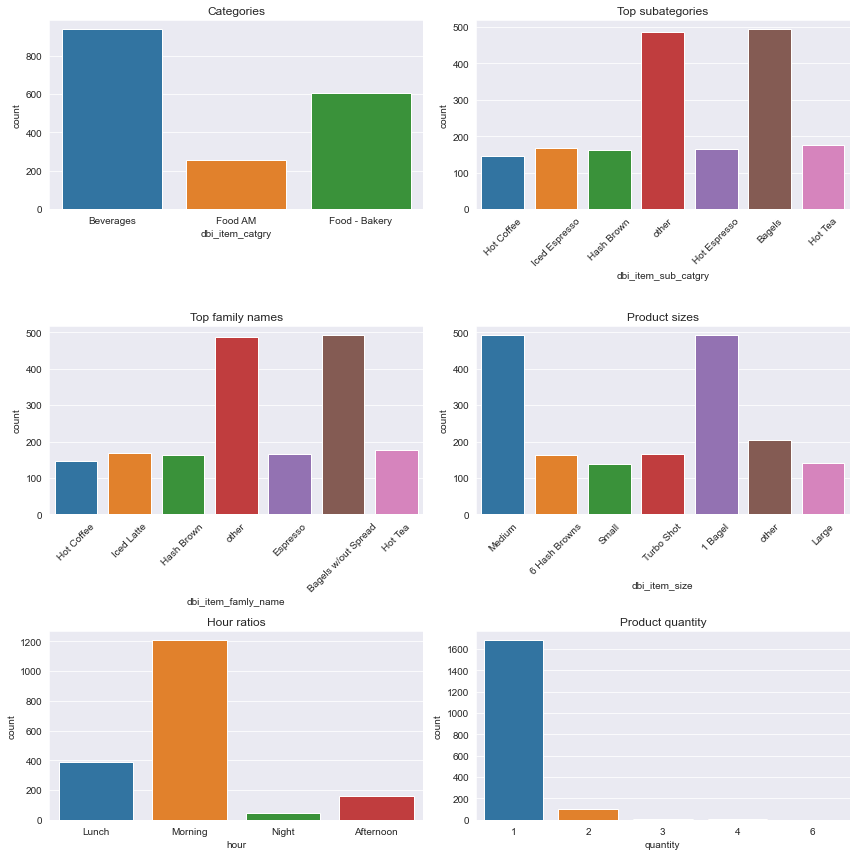

Cluster number: 8
Cluster size: 2623

Mean price: 2.662
Mean customers count: 12.915
Mean freq: 0.172



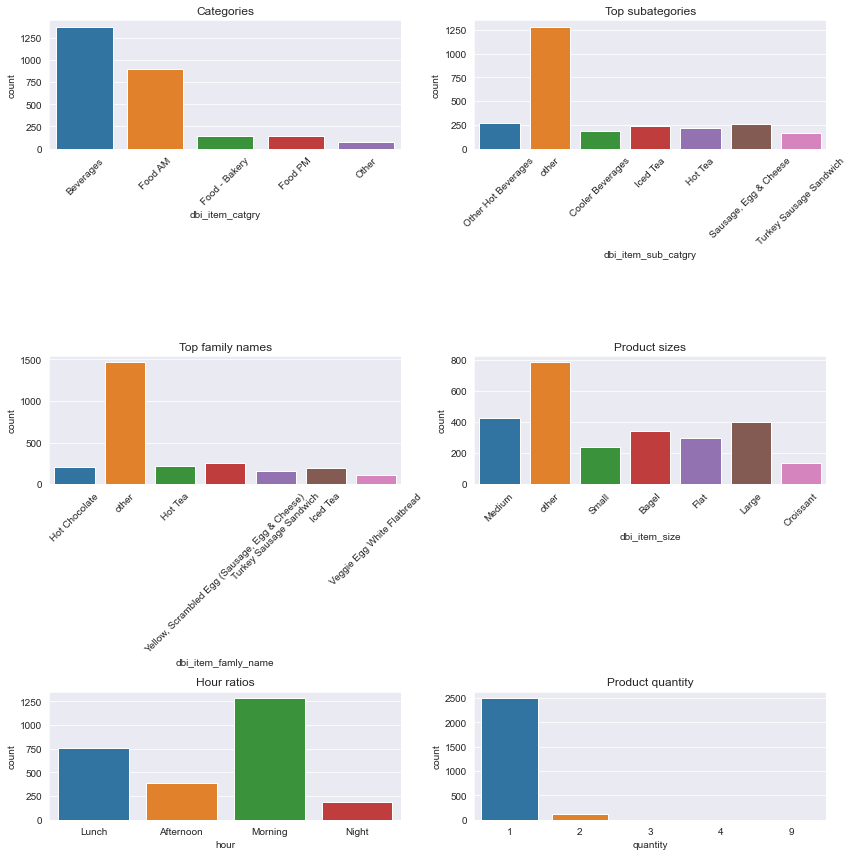

Cluster number: 9
Cluster size: 1824

Mean price: 3.397
Mean customers count: 11.010
Mean freq: 0.219



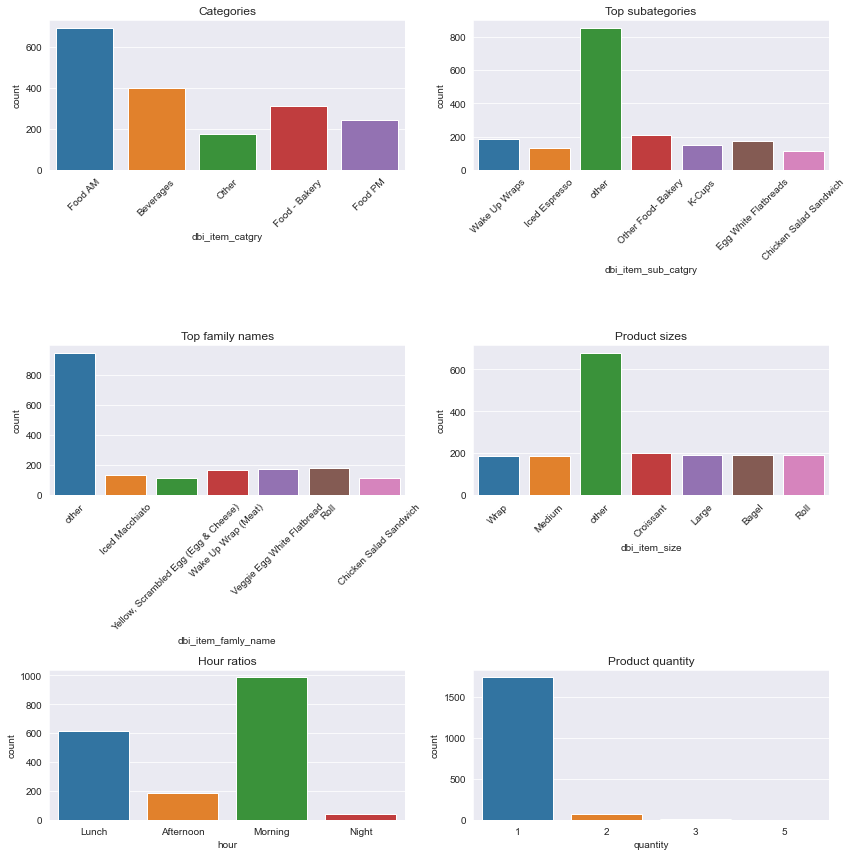

Cluster number: 10
Cluster size: 2310

Mean price: 1.151
Mean customers count: 99.000
Mean freq: 1.000



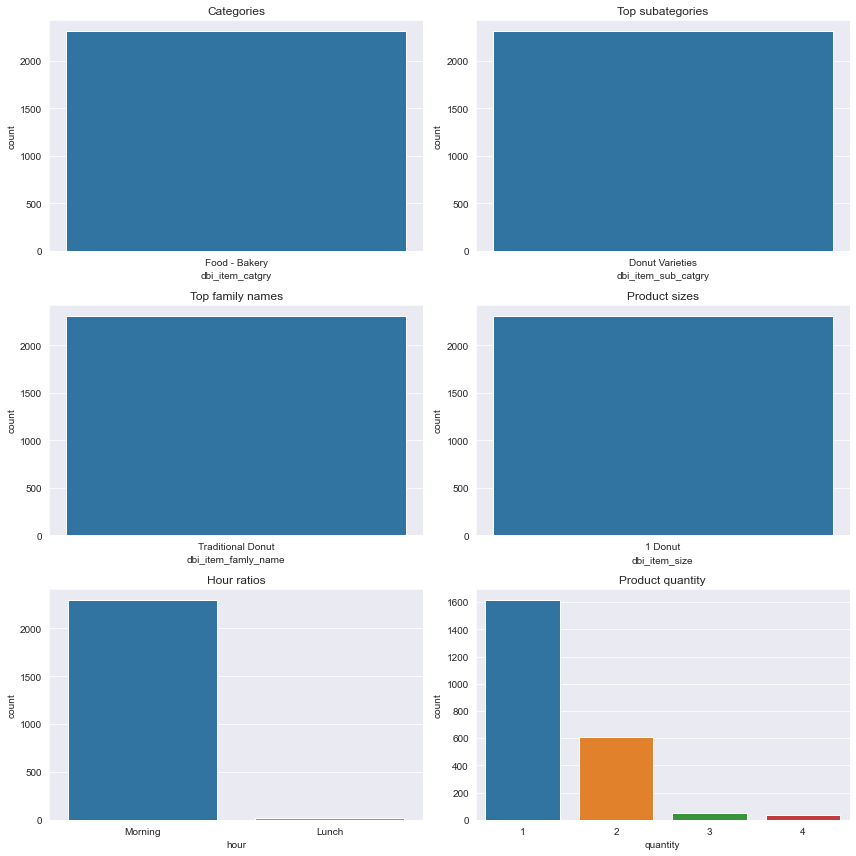

Cluster number: 11
Cluster size: 2378

Mean price: 1.685
Mean customers count: 74.984
Mean freq: 0.918



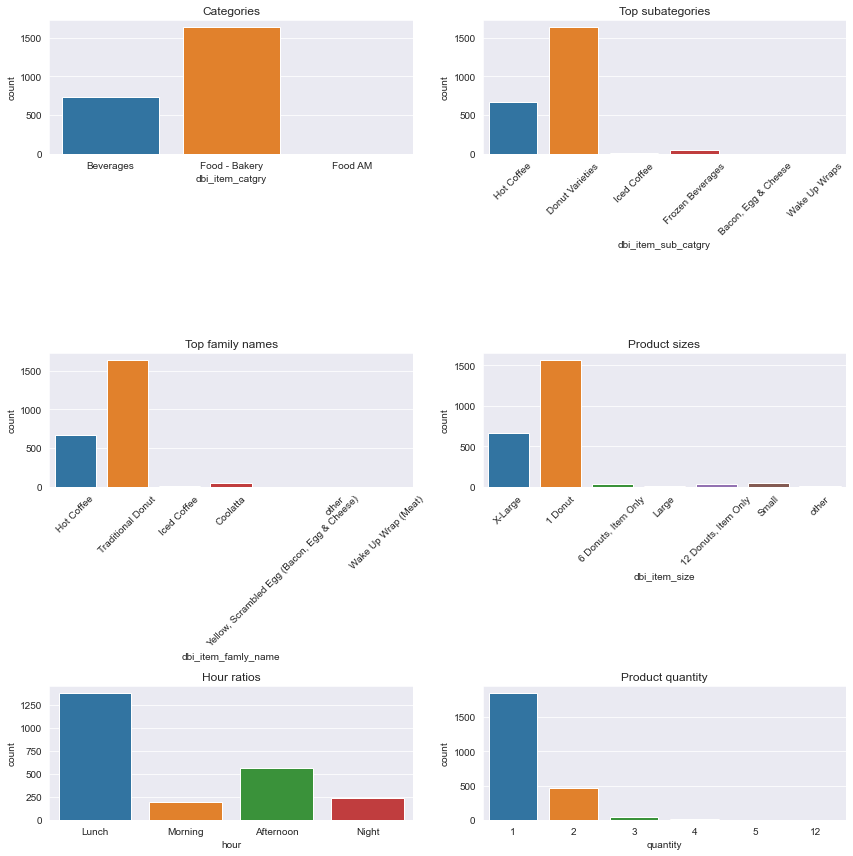

Cluster number: 12
Cluster size: 932

Mean price: 2.411
Mean customers count: 22.527
Mean freq: 0.453



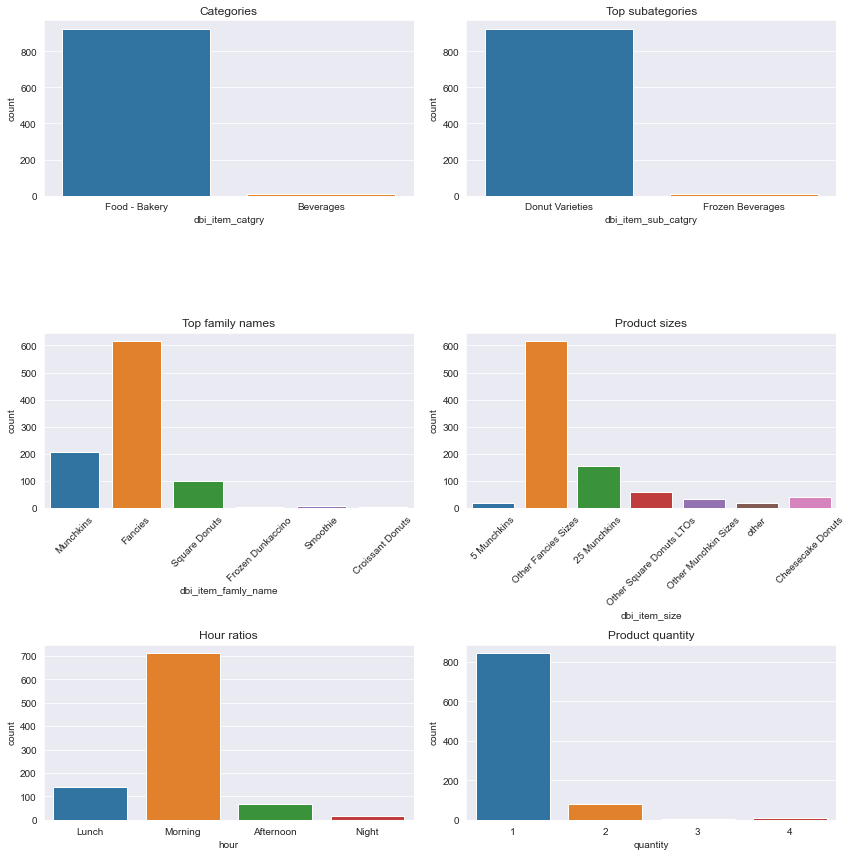

Cluster number: 13
Cluster size: 1186

Mean price: 1.809
Mean customers count: 36.565
Mean freq: 0.740



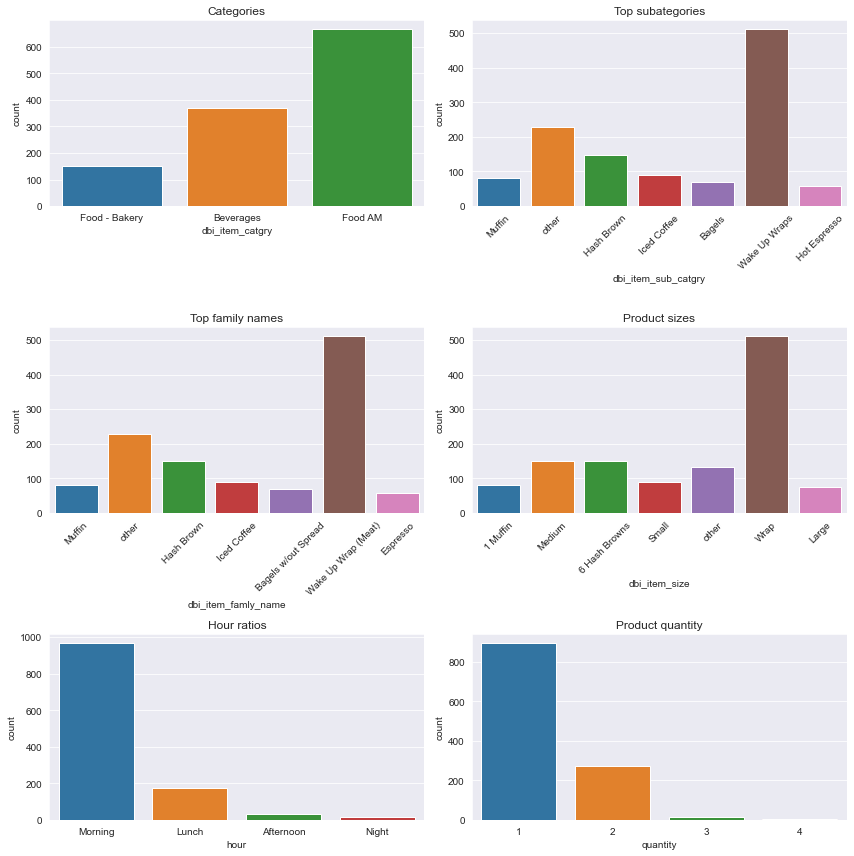

Cluster number: 14
Cluster size: 2063

Mean price: 1.650
Mean customers count: 71.151
Mean freq: 0.963



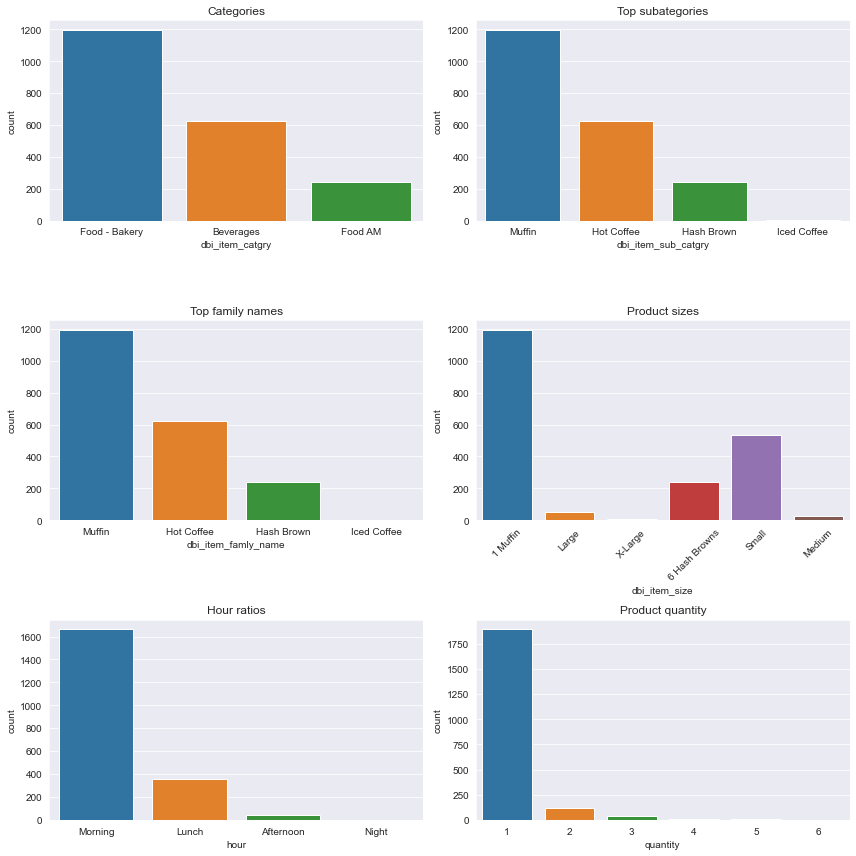

Cluster number: 15
Cluster size: 2334

Mean price: 1.795
Mean customers count: 33.728
Mean freq: 0.682



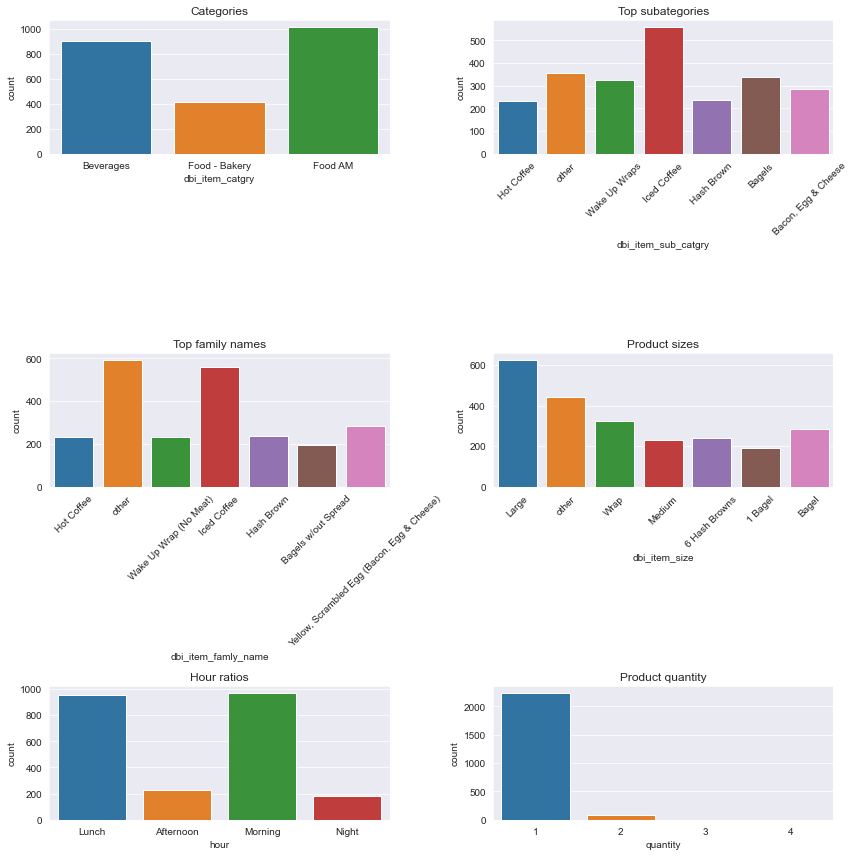

Cluster number: 16
Cluster size: 781

Mean price: 2.211
Mean customers count: 78.817
Mean freq: 0.933



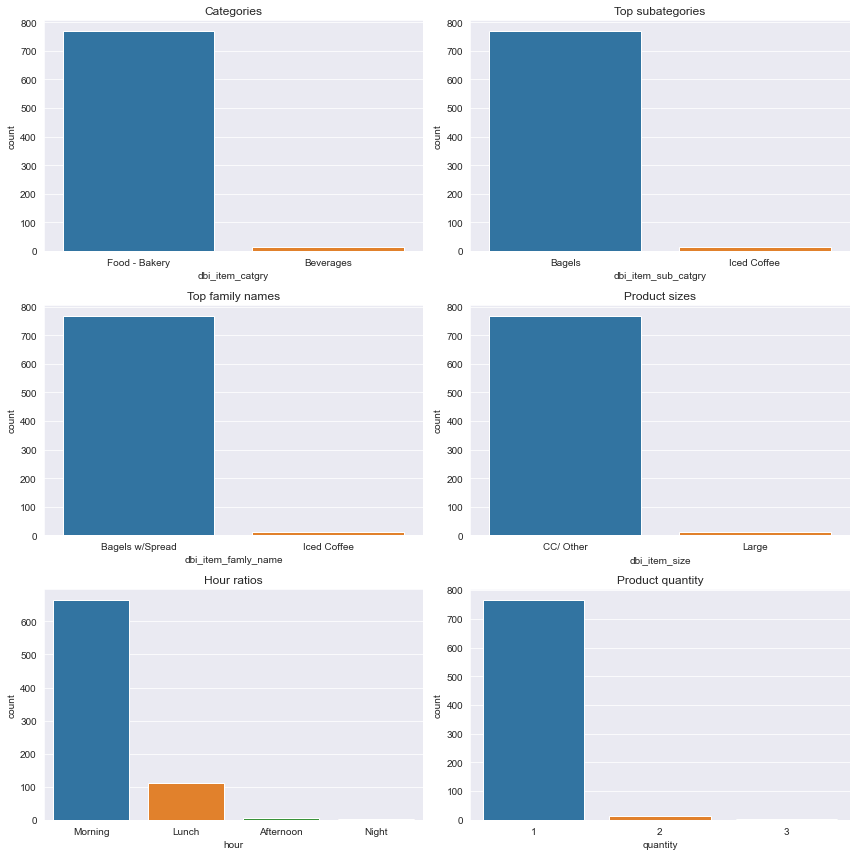

Cluster number: 17
Cluster size: 1959

Mean price: 2.463
Mean customers count: 44.000
Mean freq: 0.997



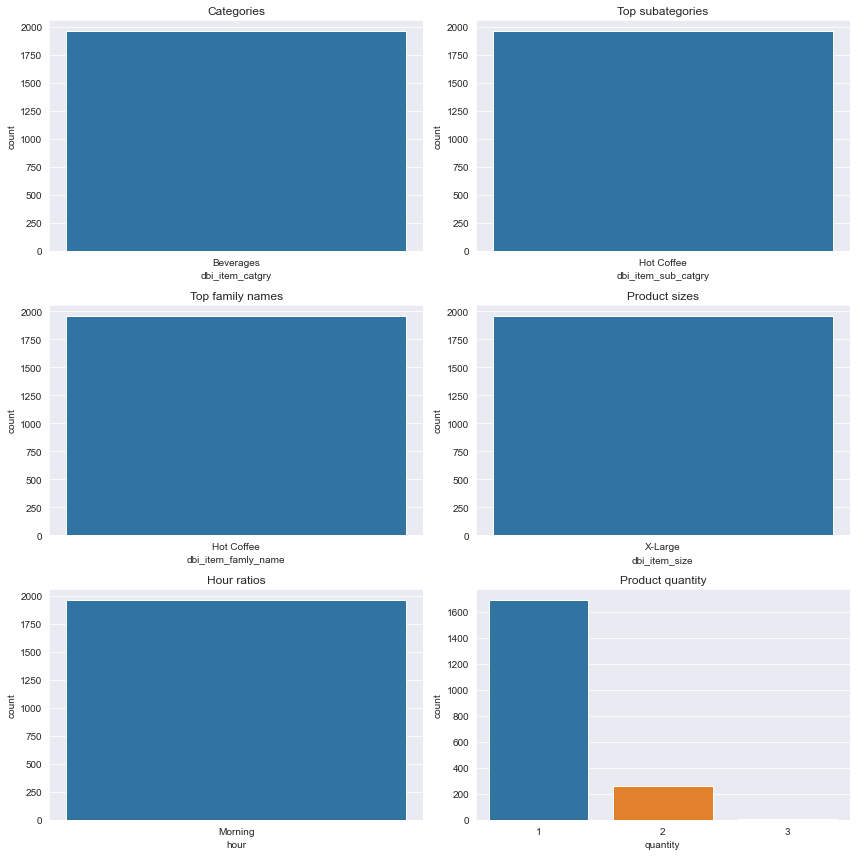

Cluster number: 18
Cluster size: 1173

Mean price: 1.613
Mean customers count: 27.487
Mean freq: 0.673



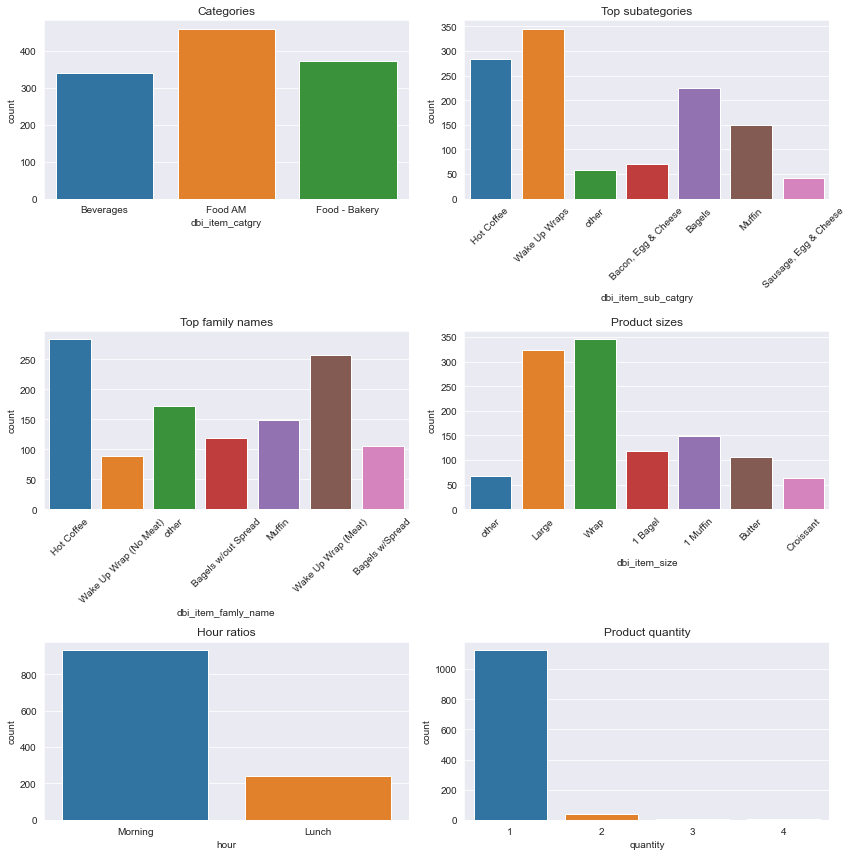

Cluster number: 19
Cluster size: 2023

Mean price: 1.526
Mean customers count: 33.129
Mean freq: 0.657



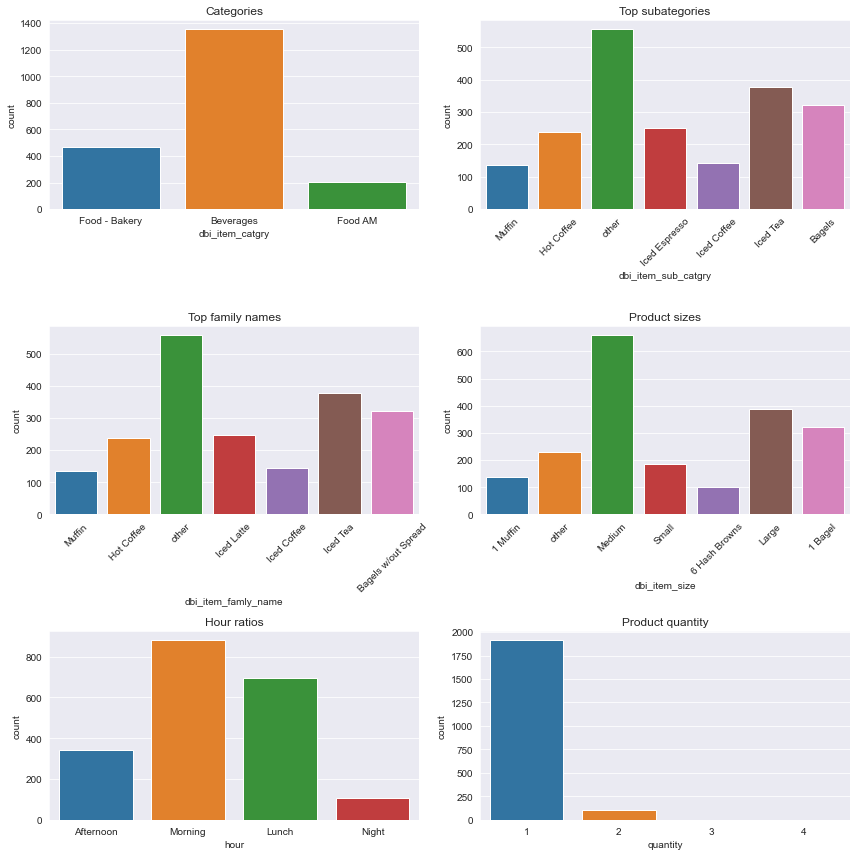

Cluster number: 20
Cluster size: 2301

Mean price: 2.331
Mean customers count: 71.910
Mean freq: 1.000



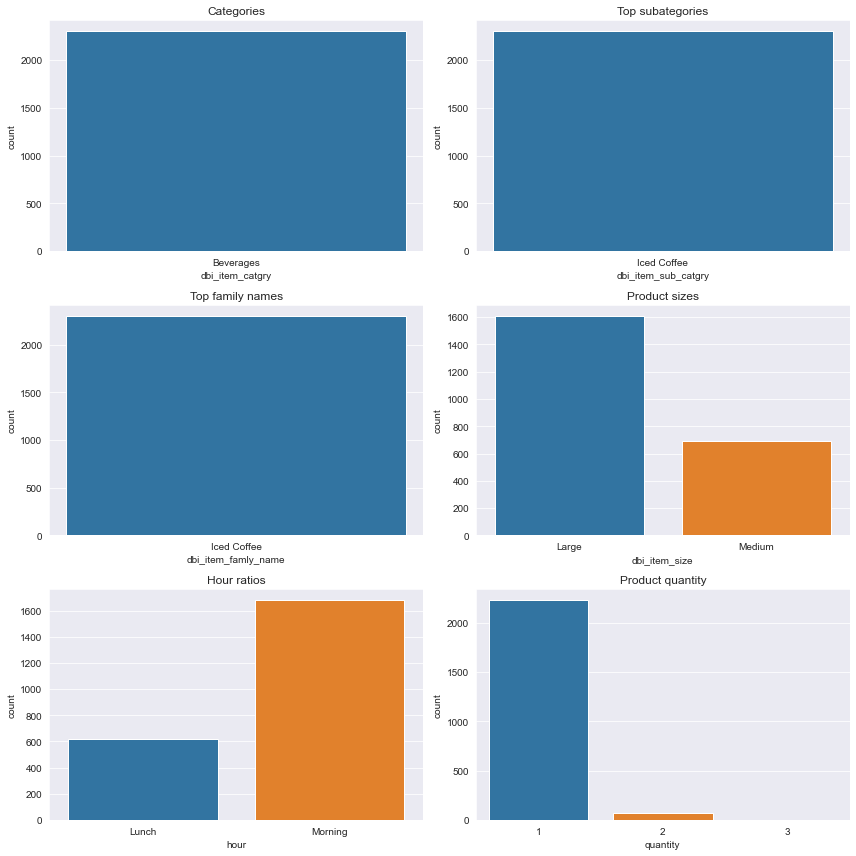

Cluster number: 21
Cluster size: 3229

Mean price: 2.293
Mean customers count: 77.675
Mean freq: 1.000



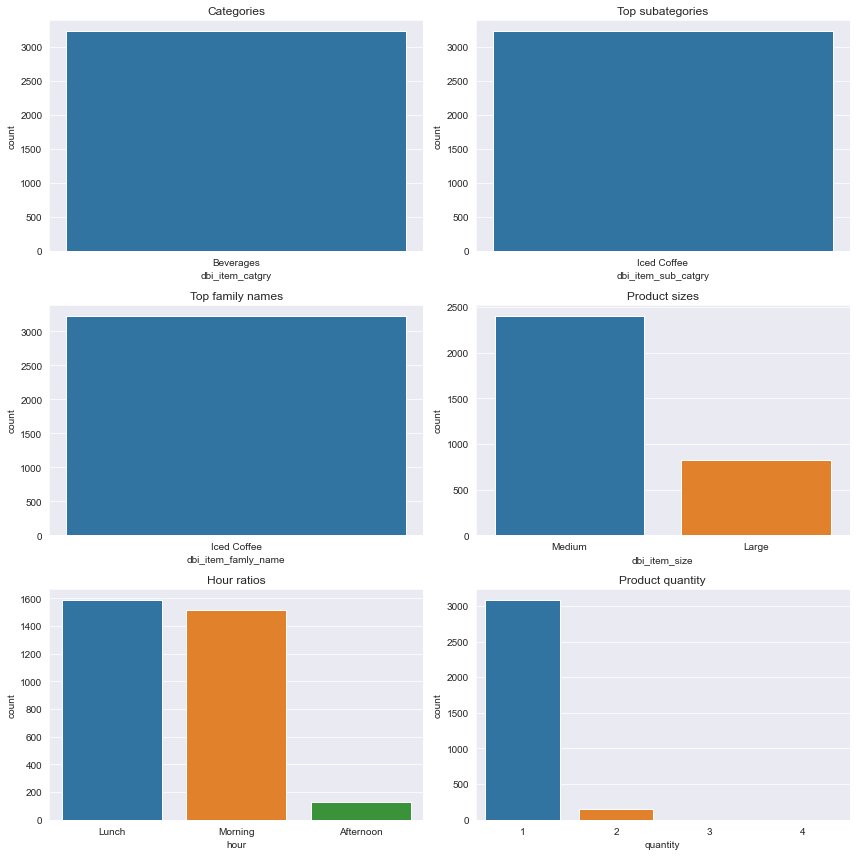

Cluster number: 22
Cluster size: 1117

Mean price: 1.720
Mean customers count: 64.489
Mean freq: 0.974



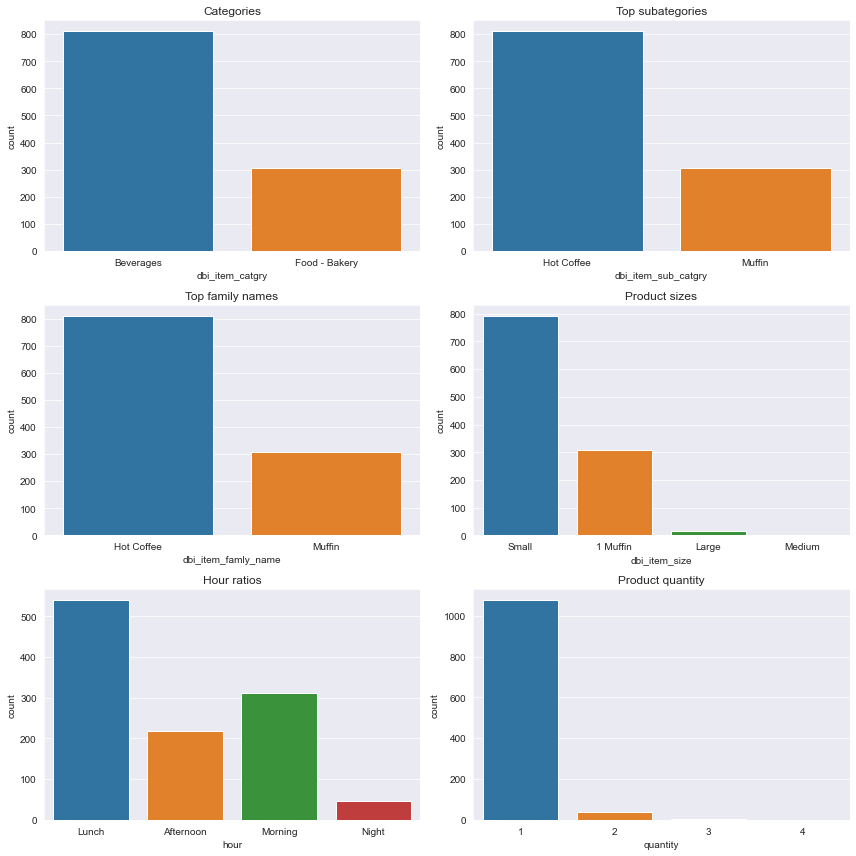

Cluster number: 23
Cluster size: 522

Mean price: 2.056
Mean customers count: 15.044
Mean freq: 0.317



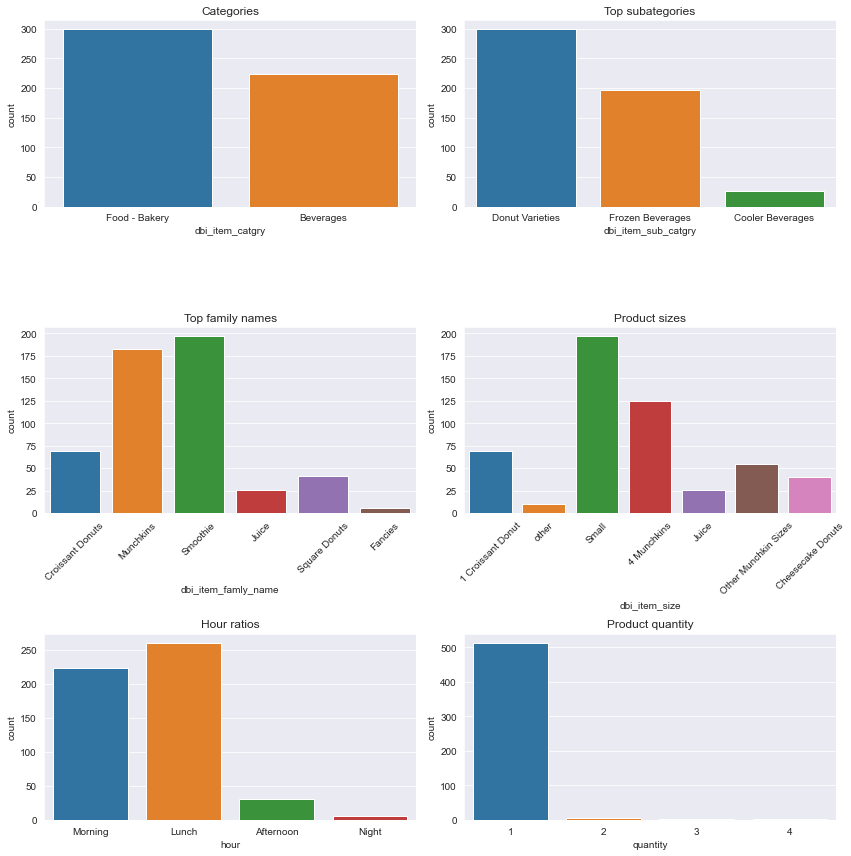

Cluster number: 24
Cluster size: 1113

Mean price: 1.102
Mean customers count: 15.500
Mean freq: 0.295



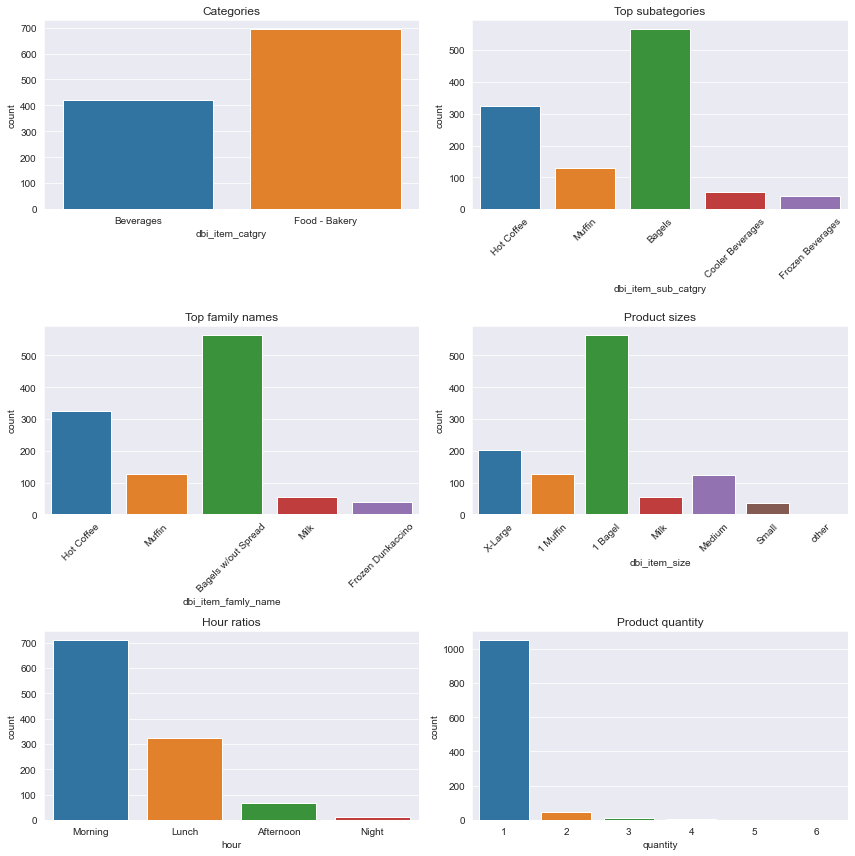

In [148]:
for k in sorted(data['kmeans_25'].unique()):
    describe_cluster(k, df, data['kmeans_25'])

### II. Recommender system (25)

1. Prepare user-item data as it was done during the seminar: User, Item, Score. You may construct Score (e.g. see seminar) any way you want, but you must explain it in your report.  

2. Split your data into train and test sets (as Leonid explained during the lecture): some of the user-item pairs go to the train set and some to the test set.


3. Build a recommender system using cluster groups (if you have about 20-40 clusters) or items subcategories (75 most frequent values of the  `dbi_item_famly_name`  attribute) as items and `dd_card_number` as users. You may want to play with a number of neighbours in your KNN recommender model. 

4. Compute 3 different recommender performance scores, which were explained during the lecture or seminar to assess the quality of your recommendations (use appropriate metrics).

5. Write a report.  In your report you should present the following information:
   - Report computed performance scores.
   - Elaborate on the quality of your recommendations.
   - Provide 3-5 examples of `good` recommendations suggested by your recommender system.
   - Provide 3-5 examples of `bad` recommendations suggested by your recommender system.
   - You may report any additional information you find potentially useful to assess the quality of your recommendations: e.g for a couple of customers compute the price of their average purchase (or an item in purchase) and compare it with the average price of recommended items.
   - You may use any visualisations you find useful
